In [1]:
#Load the numpy and scipy libraries
import numpy as np
from scipy.spatial import Delaunay
import numba
from numba import float32, float64, int64
from typing import Union
from matplotlib import pyplot as plt

@numba.jit(nopython=True, nogil=True)
def tetrahedron_volume(sim: int64[:], points: float64[:,:]):
    return abs(np.linalg.det(np.stack((points[sim[1]] - points[sim[0]], 
                                       points[sim[2]] - points[sim[0]],
                                       points[sim[3]] - points[sim[0]])))) / 6

@numba.jit(nopython=True, nogil=True)
def compute_densities(pts: float64[:,:], simps: float64[:,:],
                      m: Union[float64, float64[:]]) -> np.ndarray:
    M = len(pts)
    rho = np.zeros(M, dtype='float64')
    for sim in simps:
        vol = tetrahedron_volume(sim, pts)
        for index in sim:
            rho[index] += vol
    return (3 + 1) * m / rho

@numba.jit(nopython=True, nogil=True)
def compute_gradients(pts, simps, rho):
    N = len(simps)
    Drho = np.zeros((N, 3), dtype='float64')
    Dv   = np.zeros((N, 3, 3), dtype='float64')

    for i, s in enumerate(simps):
        [p0, p1, p2, p3] = pts[s]
        [r0, r1, r2, r3] = rho[s]
        #[v0, v1, v2, v3] = v[s]

        Ainv: float64[:,:] = np.linalg.inv(np.stack((p1 - p0, p2 - p0, p3 - p0)))
        Drho[i] = Ainv @ np.array([r1 - r0, r2 - r0, r3 - r0])
        #Dv[i] = Ainv @ np.stack((v1 - v0, v2 - v0, v3 - v0))
    return Drho

@numba.jit(nopython=True, nogil=True)
def map_affine(a, b, c):
    assert(len(a) == len(b) == len(c))
    result = np.zeros_like(a)
    for i in range(len(a)):
        result[i] = a[i] + b[i] @ c[i]
    return result

#The Delaunay Tesselation Field Estimator 
class DTFE:
    def __init__(self, points, m):
        print("Delaunay Tesselation Field Estimator initialization:")
        #self.velocities = velocities
        print("\t-Evaluate Delaunay tessellation")
        self.delaunay = Delaunay(points)
        
        #Area of a triangle
        
        #The density estimate
        print("\t-Evaluate density estimate")
        self.rho = compute_densities(self.delaunay.points, self.delaunay.simplices, m)
        #The gradients
        print("\t-Evaluate gradients")
        self.Drho = compute_gradients(self.delaunay.points, self.delaunay.simplices,
                                               self.rho)

    #The interpolations
    def density(self, x, y, z):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y, z])
        pointIndex   = self.delaunay.simplices[simplexIndex][...,0]
        return map_affine(self.rho[pointIndex], self.Drho[simplexIndex],
                          np.c_[x, y, z] - self.delaunay.points[pointIndex])

   

In [2]:
L = 128
sigma = 8
gamma = 1

def power(k, gamma):
    return k**gamma

def GRF(L, gamma, sigma):
    kRange = 2 * np.pi * np.fft.fftfreq(L)
    kx, ky, kz = np.meshgrid(kRange, kRange, kRange)
    k2 = kx**2 + ky**2 + kz**2
    smooth_kernel = np.exp(- sigma ** 2 * k2 / 2)
    grf = np.fft.ifftn(
        np.sqrt(power(k2, gamma)) * 
                smooth_kernel * 
                np.fft.fftn(np.random.normal(0, 1, (L, L, L)))).real
    return grf / np.std(grf)

def gradient(data):
    kRange = 2 * np.pi * np.fft.fftfreq(L)
    kx, ky, kz = np.meshgrid(kRange, kRange, kRange)
    
    datax = -np.fft.ifftn(kx * np.fft.fftn(data)).imag
    datay = -np.fft.ifftn(ky * np.fft.fftn(data)).imag
    dataz = -np.fft.ifftn(kz * np.fft.fftn(data)).imag
    
    return np.transpose(np.array([datax, datay, dataz]),(1,2,3,0))

def Zeldovich(grf, D):
    velocities = gradient(grf)
    X, Y, Z = np.meshgrid(np.arange(L), np.arange(L), np.arange(L))
    points = np.transpose(np.array([X, Y, Z]), (1,2,3,0)) + D * velocities
    return (points.reshape(L**3, 3), velocities.reshape(L**3, 3))

grf = GRF(L, gamma, sigma)
points, velocities = Zeldovich(grf, 20)
m = np.ones(len(points))

In [3]:
np.shape(points)

(2097152, 3)

In [4]:
np.max(points)

133.79004923337294

In [5]:
%%time
dtfe = DTFE(points, m)

Delaunay Tesselation Field Estimator initialization:
	-Evaluate Delaunay tessellation
	-Evaluate density estimate
	-Evaluate gradients
CPU times: user 2min 22s, sys: 4.97 s, total: 2min 27s
Wall time: 2min 29s


CPU times: user 30.1 s, sys: 857 ms, total: 30.9 s
Wall time: 31 s


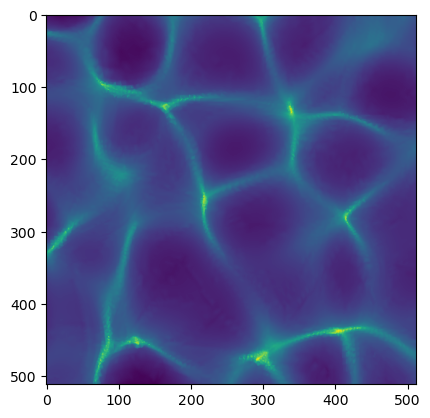

In [6]:
%%time
n = int(4 * L)
X, Y = np.meshgrid(np.arange(0.1 * L, 0.9 * L, 0.8 * L / n),   
                   np.arange(0.1 * L, 0.9 * L, 0.8 * L / n))

dens  = dtfe.density(X.flat, Y.flat, np.full_like(X, int(L / 3)).flat).reshape((n,n))
plt.imshow(dens,norm="log")

In [7]:
tester = dtfe.density(X.flat, Y.flat, np.full_like(X, int(L / 2)).flat)

In [8]:
np.shape(tester)

(262144,)

In [9]:
n = int(4 * L)
X, Y,Z = np.meshgrid(np.arange(0.1 * L, 0.9 * L, 0.8 * L / n),   
                   np.arange(0.1 * L, 0.9 * L, 0.8 * L / n),
                    np.arange(0.4 * L, 0.5 * L, 0.1 * L / n))

d  = dtfe.density(X.flat, Y.flat, Z.flat)

In [10]:
dens = d.reshape(n,n,n)

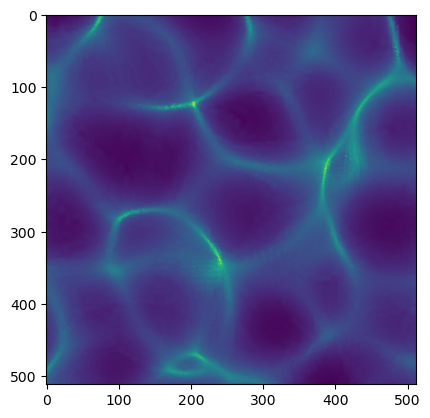

In [11]:
plt.imshow(dens[:,:,255],norm="log")

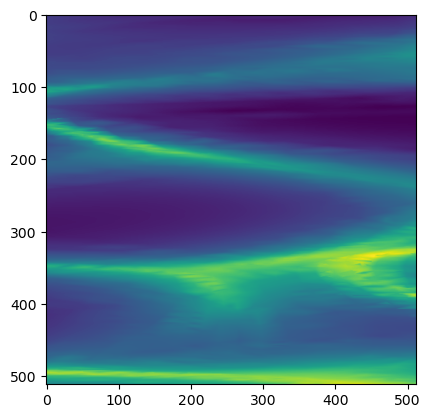

In [12]:
plt.imshow(dens[:,255,],norm="log")

# ILLUSTIS TIME

In [13]:
from pathlib import Path
import vaex
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from matplotlib import animation

from scipy.optimize import minimize, curve_fit

from scipy import interpolate
from scipy import ndimage

import illustris_python as il

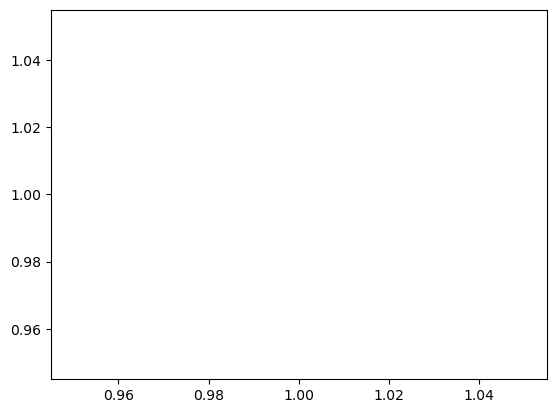

In [14]:
%matplotlib inline


plt.plot([1],[1])

font = {"weight": "normal", "size": 14}
plt.rcParams["axes.linewidth"] = 1.5  # set the value globally
plt.rc("font", **font)
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
_legend = {"frameon": True, "framealpha":0.7}
plt.rc("legend", **_legend)
plt.show()

In [15]:
path = "/net/virgo01/data/users/spirov/Nexus Project/"
df = vaex.open(path+"135.hdf5")

In [16]:
@vaex.register_function()
def correct(x):
    L = 75000
    return np.where(np.abs(x)>L/2, x-np.sign(x)*L,x)

def localizeDataFrame(absDf, x,y,z):
    rx = absDf.X - x
    ry = absDf.Y - y
    rz = absDf.Z - z
    
    L = 75000
    
    relx = rx.correct()
    rely = ry.correct()
    relz = rz.correct()
    
    
    relR = np.sqrt(relx**2 + rely**2+relz**2)
    
    theta = np.arccos(relz/relR)
    fi = np.arctan2(rely,relx)
    
    relDf = absDf.copy()
    
    Vaway = (relx*absDf.Vx+rely*absDf.Vy+relz*absDf.Vz)/relR
    
    
    relDf["relX"] = relx
    relDf["relY"] = rely
    relDf["relZ"] = relz
    
    
    
    relDf["R"] = relR
    relDf["Th"] = theta
    relDf["Fi"] = fi
    relDf["Vr"] = Vaway
    
#    cz = Vaway * relR/10
    
    
 #   relDf["CZ"] = cz
    
    
    return relDf
    
    

def czPlot(df,tolAng = np.pi*0.3, rad = 3.75e3,name="Relative Plot",GodMode = True,subPlot = None):
    
    tolAng = (np.pi/2)-tolAng
    
    filt = (df.Th>tolAng)*(df.Th<(np.pi-tolAng))
    
    df = df[filt]
    
    if not subPlot:
        plt.figure(figsize=(24,16))
        subPlot = plt.subplot(projection='polar')
        plt.title(f"cz Plot from {name}")
    else:
        if GodMode:
            t = "Real Distribution"
        else:
            t = "Observed Distribution"
        subPlot.set_title(t)
   
    
    r = df.R.values/1e3
    phi = df.Fi.values
    vr = df.Vr.values
    
    
    
    rh= r
    
    cz = rh*100
    
    if not GodMode:
         cz+= vr
            
#    rad *=1e3
   
    filt = cz<rad
    
    cz = cz[filt]
    phi = phi[filt]
    
    subPlot.scatter(phi, cz,alpha=0.01,s=0.01,color='indigo')
    thits = np.linspace(0,2*np.pi,100)
    subPlot.plot(thits,np.full(100,rad),c='black')
    subPlot.set_ylim(0,rad)
    
    # plt.show()
    


In [17]:
fx,fy,fz=2e4,4.9e4,4.9e4
fatDf = localizeDataFrame(df, fx,fy,fz)

In [18]:
cutFat = fatDf[fatDf.R<2e4]

In [19]:
cutFat

#,ID,X,Y,Z,Vx,Vy,Vz,relX,relY,relZ,R,Th,Fi,Vr
0,32968543,19752.85,47539.44,49008.516,-135.20187,41.566643,45.421795,-247.150390625,-1460.55859375,8.515625,1481.3464271507216,1.5650477242088041,-1.7384247444413272,-18.16491126933853
1,36253968,19752.7,47542.203,49009.96,-31.186357,16.989326,-18.758793,-247.30078125,-1457.796875,9.9609375,1478.657710710124,1.5640598030089048,-1.7388366545102725,-11.660191206865203
2,29689043,19753.451,47542.32,49005.54,-76.03529,103.81716,-63.191254,-246.548828125,-1457.6796875,5.5390625,1478.393410839377,1.567049641089556,-1.7383484442439092,-89.91908000993264
3,32967668,19754.02,47543.734,49007.727,-280.15137,61.993305,2.704936,-245.98046875,-1456.265625,7.7265625,1476.9142362815712,1.565564744922642,-1.7381286736312223,-14.45314450133523
4,29685393,19749.08,47541.43,49009.867,-104.42354,81.94567,91.027435,-250.919921875,-1458.5703125,9.8671875,1480.0288933292024,1.5641293889796444,-1.7411601797900627,-62.44701888804953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"12,525,530",92762639,2145.5051,44349.547,56502.625,469.32562,445.96976,-115.38789,-17854.494140625,-4650.453125,7502.625,19917.30546976824,1.1845771861793535,-2.8867900159055457,-568.3120712017894
"12,525,531",92762664,2189.4531,44211.375,56484.957,441.8732,412.88837,-192.57735,-17810.546875,-4788.625,7484.95703125,19904.047104467376,1.1852644614742103,-2.8789394039156107,-567.1511925981472
"12,525,532",92762689,2172.3257,44393.973,56548.94,469.03006,478.41135,-144.92229,-17827.673828125,-4606.02734375,7548.94140625,19900.451210170624,1.1817186502023227,-2.888757707221858,-585.8812141992311
"12,525,533",92763039,2231.7698,43822.457,56570.17,435.21503,378.3565,-223.70535,-17768.23046875,-5177.54296875,7570.171875,19995.611203484365,1.1825220942156027,-2.8580505153876046,-569.3972454162682


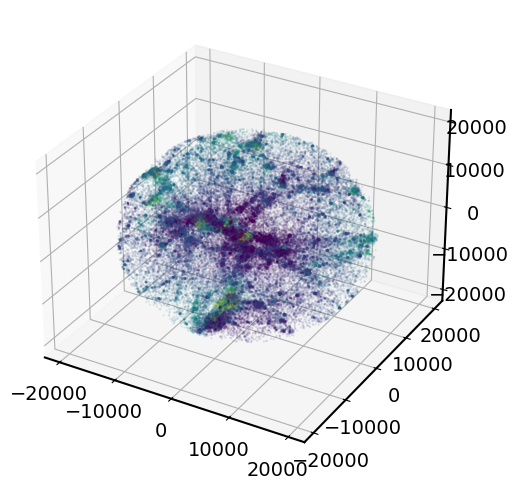

In [20]:
#%matplotlib notebook
n = 100
localFrame = cutFat
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(projection='3d')

Xs = localFrame.relX.values
Ys = localFrame.relY.values
Zs = localFrame.relZ.values
vrs = localFrame.Vr.values

sc = ax.scatter(Xs[::n],Ys[::n],Zs[::n],s=0.5,alpha = .1,c=vrs[::n],vmin = -500,vmax=500)

plt.show()



In [21]:
#cutFat["X"] = cutFat.X-1000


rrx =cutFat.relX.mean()
rry = cutFat.relY.mean()
rrz = cutFat.relZ.mean()

print(rrx,rry,rrz)

-756.0935015249286 -1408.9074772660658 -224.52594947400826


In [22]:
Xs = []
Ys = []
Zs = []

fx,fy,fz=2e4,4.9e4,4.9e4

w=1

for i in range(100):
    fatDf = localizeDataFrame(df, fx,fy,fz)
    cutFat = fatDf[fatDf.R<2e4]
    rrx =cutFat.relX.mean()
    rry = cutFat.relY.mean()
    rrz = cutFat.relZ.mean()

    Xs.append(rrx)
    Ys.append(rry)
    Zs.append(rrz)
    
    fx+=rrx*w
    fy+=rry*w  # flip + to find local minimum
    fz+=rrz*w
    
    r=np.sqrt(rrx**2+rry**2+rrz**2)
    
    print(i,r)
    
    if i==20:
        w=0.1
    
    if r < 1e-1:
        break

0 1614.6546270121241
1 1318.915900568416
2 864.3355199758468
3 455.98490471071864
4 188.52209136074327
5 86.06932916434174
6 39.86568115190001
7 21.703654527465332
8 13.468496629611607
9 8.524229409708298
10 5.303643342171912
11 3.0706352538257478
12 1.8577713094137531
13 1.1336152934113644
14 0.6607708146897905
15 0.3827275209400411
16 0.19706839504233797
17 0.1184940135461754
18 0.06847728571117064


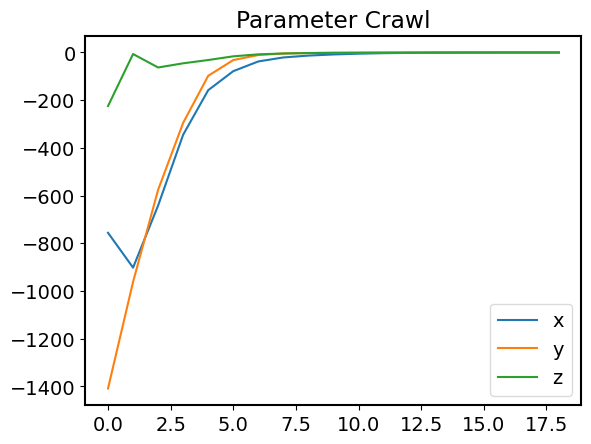

In [23]:
plt.plot(Xs,label='x')
plt.plot(Ys,label='y')
plt.plot(Zs,label='z')
plt.title('Parameter Crawl')
#plt.yscale('log')
plt.legend()
plt.show()

In [24]:
Rs = np.sqrt(np.square(Xs)+np.square(Ys)+np.square(Zs))

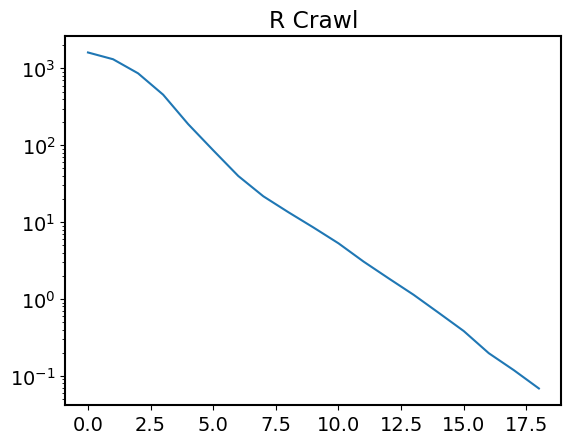

In [25]:
plt.plot(Rs,label='x')
plt.title('R Crawl')
plt.yscale('log')
plt.show()

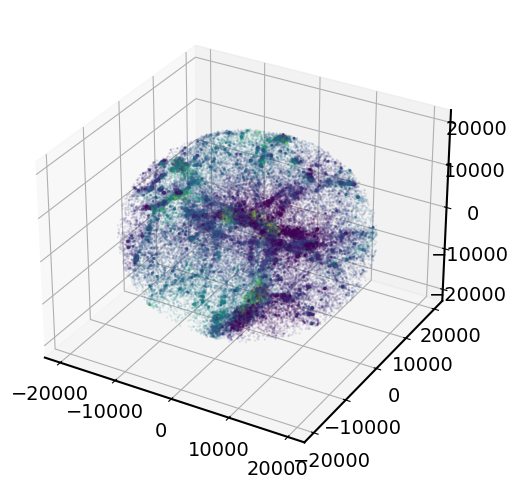

In [26]:
#%matplotlib notebook
n = 100
localFrame = cutFat
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(projection='3d')

Xs = localFrame.relX.values
Ys = localFrame.relY.values
Zs =  localFrame.relZ.values
vrs = localFrame.Vr.values

sc = ax.scatter(Xs[::n],Ys[::n],Zs[::n],s=0.5,alpha = .1,c=vrs[::n],vmin = -500,vmax=500)

plt.show()



In [27]:
print(f"Center is at {fx},{fy},{fz}")
fatDf = localizeDataFrame(df, fx,fy,fz)

Center is at 17026.872969109718,45608.2650390964,48593.901957099086


In [28]:
Xs = fatDf.relX.values
Ys = fatDf.relY.values
Zs = fatDf.relZ.values

wid = 750




cond = (Zs>-wid/2)*(Zs<wid/2)

Xs = Xs[cond]
Ys = Ys[cond]
Zs = Zs[cond]

p=np.array((Xs,Ys,Zs)).T
m=np.ones_like(Xs)

In [29]:
%%time
dtfe = DTFE(p, m)

Delaunay Tesselation Field Estimator initialization:
	-Evaluate Delaunay tessellation
	-Evaluate density estimate
	-Evaluate gradients
CPU times: user 2min 4s, sys: 2.66 s, total: 2min 7s
Wall time: 2min 7s


In [30]:
n=128
L = 75000
X,Y,Z = np.meshgrid(np.linspace(-L/2,L/2,n),np.linspace(-L/2,L/2,n),np.linspace(-wid/2,wid/2,n))

d= dtfe.density(X.flatten(),Y.flatten(),Z.flatten())

In [31]:
den = d.reshape(n,n,n)

In [32]:
dens = den[1:n-1,1:n-1,1:n-1]

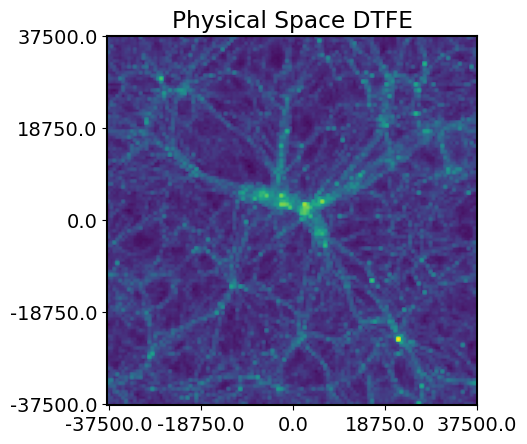

In [33]:
plt.imshow(dens[:,:,int(n/2 -1)],norm="log",origin="lower")
plt.yticks(np.linspace(0,n-2,5), np.linspace(-L/2,L/2,5))
plt.xticks(np.linspace(0,n-2,5), np.linspace(-L/2,L/2,5))


#plt.axvline(17026.872969109718*n/L,label="Cluster Center",c='r')
#plt.axhline(45608.2650390964*n/L,c='r')
#plt.legend()
plt.title("Physical Space DTFE")
plt.show()

> Bro Ken

In [34]:
Th = fatDf.Th.values
R = fatDf.R.values
Fi = fatDf.Fi.values
Vr = fatDf.Vr.values
CZ = R + Vr*10

phaseX = CZ*np.sin(Th)*np.cos(Fi)
phaseY = CZ*np.sin(Th)*np.sin(Fi)
phaseZ = CZ*np.cos(Th)


cond1 = (phaseZ>-wid/2)*(phaseZ<wid/2)

phaseX = phaseX[cond1]
phaseY = phaseY[cond1]
phaseZ = phaseZ[cond1]



php=np.array((phaseX,phaseY,phaseZ)).T
pm = np.ones_like(phaseX)

In [35]:
len(phaseZ)

2216105

In [36]:
%%time
phasedtfe = DTFE(php, pm)

Delaunay Tesselation Field Estimator initialization:
	-Evaluate Delaunay tessellation
	-Evaluate density estimate
	-Evaluate gradients
CPU times: user 3min 23s, sys: 8.03 s, total: 3min 31s
Wall time: 3min 34s


In [37]:

X,Y,Z = np.meshgrid(np.linspace(-L/2,L/2,n),np.linspace(-L/2,L/2,n),np.linspace(-wid/2,wid/2,n))

czdens= phasedtfe.density(X.flatten(),Y.flatten(),Z.flatten()).reshape(n,n,n)[1:n-1,1:n-1,1:n-1]

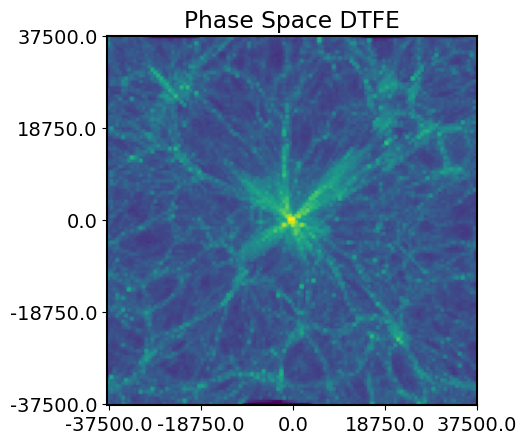

In [38]:
plt.imshow(czdens[:,:,int(n/2-1)],norm="log",origin="lower")
plt.yticks(np.linspace(0,n-2,5), np.linspace(-L/2,L/2,5))
plt.xticks(np.linspace(0,n-2,5), np.linspace(-L/2,L/2,5))


#plt.axvline(-rY*n/L,label="Cluster Center",c='r')
#plt.axhline(-rX*n/L,c='r')
plt.title("Phase Space DTFE")
plt.show()

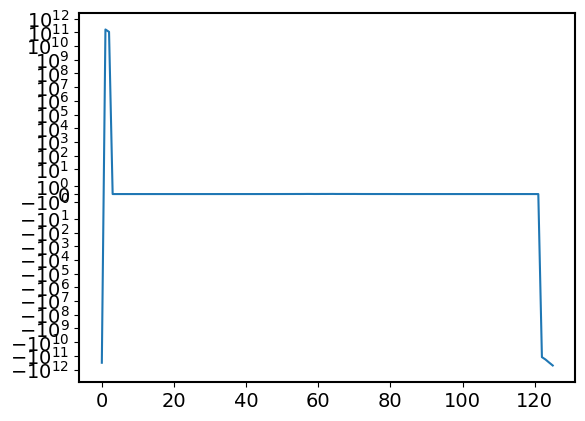

In [39]:
zS = np.sum(np.sum(czdens,0),0)
#zS = zS[zS>0]
plt.plot(np.arange(len(zS)),zS)
plt.yscale('symlog')

> smoothing


In [40]:
def smoothDensity(dens,sigma):
    f_k = np.fft.fftn(dens)
    G = ndimage.fourier_gaussian(f_k,sigma)
    f_x = np.fft.ifftn(G)
    return f_x
    
    

In [41]:
smoothD = smoothDensity(dens,np.pi/10).real

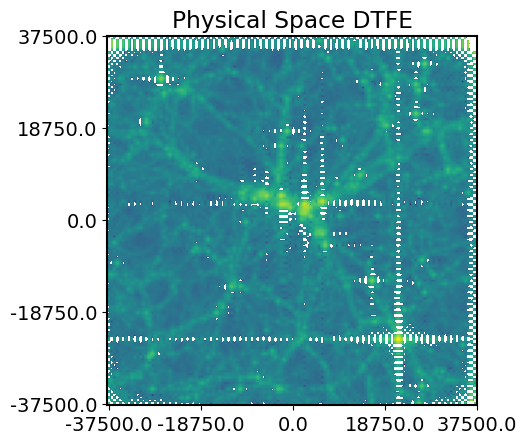

In [42]:

plt.imshow(smoothD[:,:,int(n/2-1)],norm="log",origin="lower")
plt.yticks(np.linspace(0,n-2,5), np.linspace(-L/2,L/2,5))
plt.xticks(np.linspace(0,n-2,5), np.linspace(-L/2,L/2,5))

plt.title("Physical Space DTFE")
plt.show()

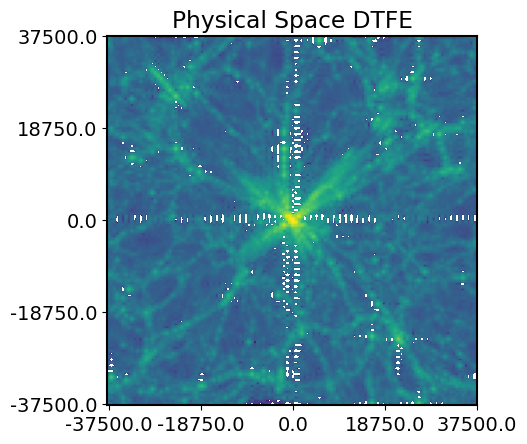

In [43]:
smoothDcz = smoothDensity(czdens[:,:,np.abs(zS)<1e3],np.pi/10).real


plt.imshow(smoothDcz[:,:,int(n/2-1)],norm="log",origin="lower")
plt.yticks(np.linspace(0,n-2,5), np.linspace(-L/2,L/2,5))
plt.xticks(np.linspace(0,n-2,5), np.linspace(-L/2,L/2,5))

plt.title("Physical Space DTFE")
plt.show()